# Note: The official one has been moved to https://colab.research.google.com/notebook#fileId=1R6U5gDM_bdwlmcR--QrWGdmUENvW-hCu&scrollTo=AseJUXUkIn0q&printMode=true .

For a pure velocity controller, the output is the motor speed (velocity) and the input is the distance moved. This can be written as

$$x'=m \left(p\left(SP-x\right)+i \int \left(SP-x\right) dt +d \left(\frac{d\left(SP-x\right)}{dt} \right)\right)$$

Discretization yields

$$\frac{x_j-x_{j-1}}{\Delta t}=m \left(p\left(SP-x_{j-1}\right)+i \sum_n \left(SP-x_n\right) \cdot \Delta t +d \left(\frac{x_{j-2}-x_{j-1}}{\Delta t} \right)\right)$$

We are now dropping the $\Delta t$ terms for the integral and derivative terms because WPILib does not include them:

$$\frac{x_j-x_{j-1}}{\Delta t}=m \left(p\left(SP-x_{j-1}\right)+i \sum_n \left(SP-x_n\right) +d \left(x_{j-2}-x_{j-1} \right)\right)$$

Solving for $x_{j}$ is done as follows:

$$x_j-x_{j-1}=m \Delta t \left(p\left(SP-x_{j-1}\right)+i \sum_n \left(SP-x_n\right) +d \left(x_{j-2}-x_{j-1} \right)\right)$$

$$x_j=x_{j-1}+m \Delta t \left(p\left(SP-x_{j-1}\right)+i \sum_n \left(SP-x_n\right) +d \left(x_{j-2}-x_{j-1} \right)\right)$$

An elevator is lifting a certain weight, so this weight is simulated by subtracting a fixed constant from the motor output:

$$x_j=x_{j-1}+m \Delta t \left(p\left(SP-x_{j-1}\right)+i \sum_n \left(SP-x_n\right) +d \left(x_{j-2}-x_{j-1} \right) - w\right)$$

Utility functions and imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
def clamp(value, low, high):
    return max(low, min(value, high))

Solution settings and PID parameters:

 - Default update period is 50ms.
 - Encoder registers 490 clicks per rotation.
 - Motor output ranges from -1 to 1. Due to the weight the minimum power has been adjusted to compensate for the extra downwards force.
 - Setpoints jump to test both lifting and dropping responses.
 - Weight that elevator lifts is expressed as a fraction of total motor power.
 - Main power is provided by the proportional term, with the integral term "propping up" the elevator once it is in place.
 - Integral term should be performing only lifting, so it is capped to prevent it from pushing downwards.

In [3]:
# Timesteps and number of steps
nt=200
dt=0.05
# PID params
p=0.01
i=0.002
d=0.001
minout=-0.7
maxout=1
mininteg=0
maxinteg=0.8/i
motorpower=1200 # This is a pure estimation constant
elevweight=0.3 # Elevator weight in terms of motor power-subtracted from output

In [4]:
# Initialize variables
timerange=np.arange(0,nt*dt,dt)
setpointarray=np.full((nt),1000)
setpointarray[nt//2:]=0
out=np.zeros(nt)
pidoutraw=np.zeros(nt)
pidout=np.zeros(nt)
porpout=np.zeros(nt)
integout=np.zeros(nt)
derivout=np.zeros(nt)

In [5]:
# Wrapraound is safe because of constant initialization
integsum=0
for index in range(1,nt):
    err=setpointarray[index-1]-out[index-1]
    # Proportional term
    porp=p*err
    porpout[index]=porp
    # Integral term
    integsum+=err
    integsum=clamp(integsum,mininteg,maxinteg)
    integ=i*integsum
    integout[index]=integ
    # Derivative term
    deriv=d*(out[index-2]-out[index-1])
    derivout[index]=deriv
    # Add together
    newout=porp+integ+deriv
    pidoutraw[index]=newout
    # Clamp output
    newout=clamp(newout,minout,maxout)
    pidout[index]=newout
    # Write to final output
    out[index]=out[index-1]+dt*motorpower*(newout-elevweight)

After calculations, plot the PID response:

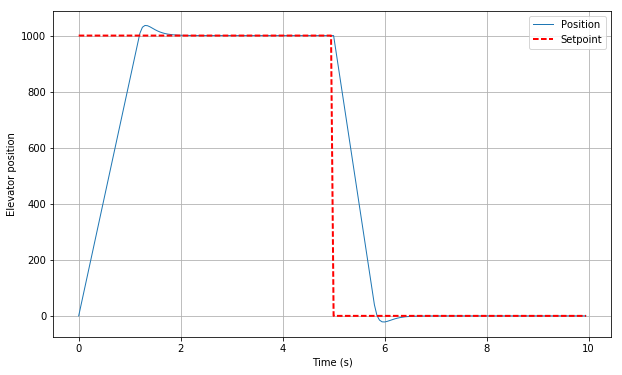

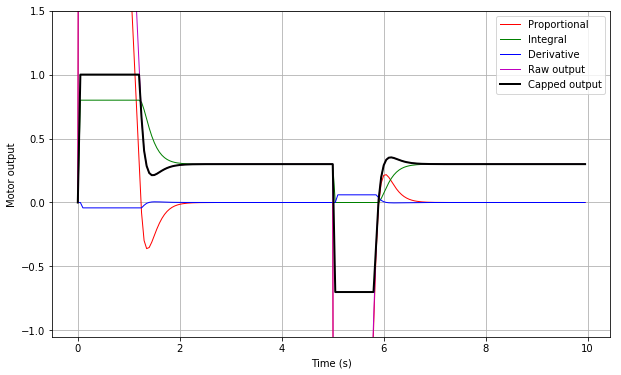

In [6]:
plt.plot(timerange,out,lw=1)
plt.plot(timerange,setpointarray,'r--',lw=2)
plt.legend(["Position","Setpoint"])
plt.xlabel("Time (s)")
plt.ylabel("Elevator position")
plt.grid()
plt.show()
plt.plot(timerange,porpout,'r',lw=1)
plt.plot(timerange,integout,'g',lw=1)
plt.plot(timerange,derivout,'b',lw=1)
plt.plot(timerange,pidoutraw,'m',lw=1)
plt.plot(timerange,pidout,'k',lw=2)
plt.xlabel("Time (s)")
plt.ylabel("Motor output")
plt.ylim(1.5*minout,1.5*maxout)
plt.legend(["Proportional","Integral","Derivative","Raw output","Capped output"])
plt.grid()
plt.show()

Close up views of the behavior near the setpoint:

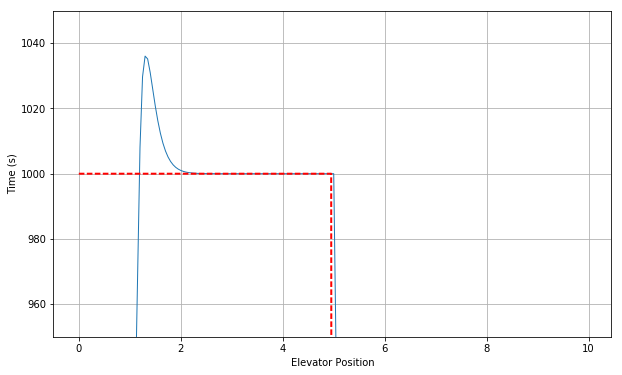

In [7]:
plt.plot(timerange,out,lw=1)
plt.plot(timerange,setpointarray,'r--',lw=2)
plt.ylim(950,1050)
plt.xlabel("Elevator Position")
plt.ylabel("Time (s)")
plt.grid()

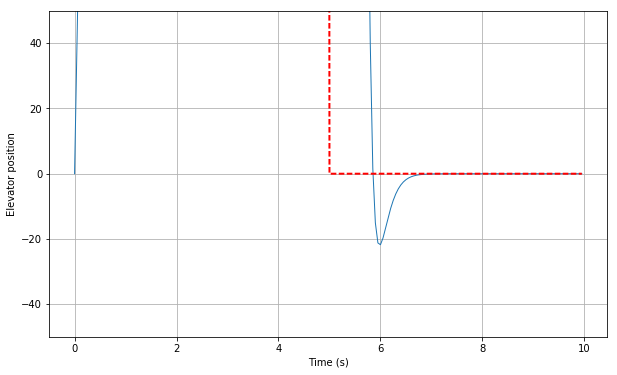

In [8]:
plt.plot(timerange,out,lw=1)
plt.plot(timerange,setpointarray,'r--',lw=2)
plt.xlabel("Time (s)")
plt.ylabel("Elevator position")
plt.ylim(-50,50)
plt.grid()